In [1]:
import numpy as np

from numpy import pi

import matplotlib.pyplot as plt

# Definition of variables

- `m` : index for the function of aziumthal angle $\phi$ (`phi`)
- `l` : index for the function of polar angle $\theta$ (`theta`)

# For single `m`

Since the azimuthal part $e^{im\phi}$ is invariant under the change of `l`, it can be factored out as a common multiplicative term.

In [2]:
m, lmax = 1, 5

In [3]:
assert lmax >= abs(m)
Nlm = lmax - abs(m) + 1
l_arr = abs(m) + np.arange(Nlm)

In [4]:
theta_arr = np.linspace(0, pi, 101)

Plm_theta = np.empty((theta_arr.size, Nlm))
dtheta_Plm_theta = np.empty((theta_arr.size, Nlm))

from tdse.propagator.spherical import Plm_and_dtheta_Plm_for_single_m
for itheta, theta in enumerate(theta_arr):
    Plm_theta[itheta], dtheta_Plm_theta[itheta] = Plm_and_dtheta_Plm_for_single_m(m, lmax, theta)

In [5]:
from vis.plot import construct_catesian_mesh_for_pcolormesh

thetapi_cmesh, l_cmesh = construct_catesian_mesh_for_pcolormesh(theta_arr/pi, l_arr)

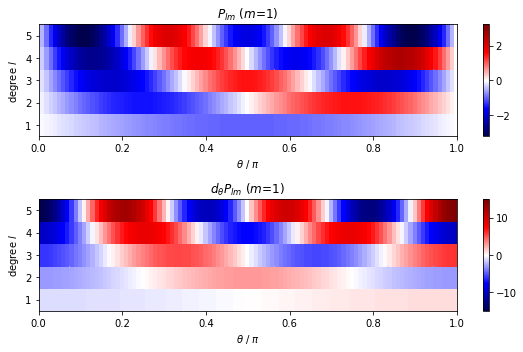

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(8,5))

ax = axes[0]
vmax = np.abs(Plm_theta).max()
pcm = ax.pcolormesh(thetapi_cmesh, l_cmesh, Plm_theta, cmap='seismic', vmin=-vmax, vmax=vmax)
cb = fig.colorbar(pcm, ax=ax)
ax.set_title(r"$P_{{lm}}$ ($m$={})".format(m))

ax = axes[1]
vmax = np.abs(dtheta_Plm_theta).max()
pcm = ax.pcolormesh(thetapi_cmesh, l_cmesh, dtheta_Plm_theta, cmap='seismic', vmin=-vmax, vmax=vmax)
cb = fig.colorbar(pcm, ax=ax)
ax.set_title(r"$d_{{\theta}}{{P_{{lm}}}}$ ($m$={})".format(m))

for ax in axes:
    ax.set_xlabel(r"$\theta$ / $\pi$")
    ax.set_ylabel("degree $l$")
    ax.set_xlim(0,1)

fig.tight_layout()

# fig.savefig("Plm-and-dtheta-Plm-including-pi-0-and-pi-test-2.png")

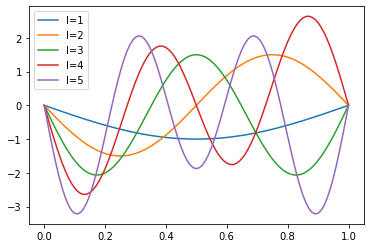

In [7]:
fig, ax = plt.subplots()
for il, l in enumerate(l_arr):
    ax.plot(theta_arr/pi, Plm_theta[:,il], label='l={}'.format(l))
ax.legend()

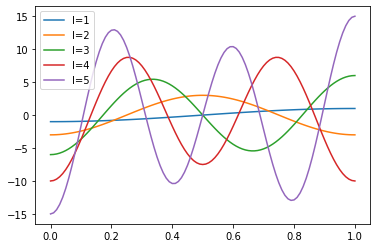

In [8]:
fig, ax = plt.subplots()
for il, l in enumerate(l_arr):
    ax.plot(theta_arr/pi, dtheta_Plm_theta[:,il], label='l={}'.format(l))
ax.legend()

# With tridiagonal matrix

In [9]:
from numpy import cos, sin
from scipy.special import lpmn

In [10]:
theta, phi = 0.001, 0.

In [11]:
Plm_all, dx_Plm_all = lpmn(m, lmax, cos(theta))

In [12]:
Plm, dx_Plm = Plm_all[-1,m:], dx_Plm_all[-1,m:]
dtheta_Plm_scipy = - sin(theta) * dx_Plm

#### Construct the dtheta tridiagonial matrix acting on an array of associate Legendre functions

In [13]:
l = l_arr

dtheta_tridiag = np.empty((3, Nlm), dtype=float)

# Fill out:
i_lower, i_diag, i_upper = 0, 1, 2

# the diagonal
dtheta_tridiag[i_diag,0] = -(l[0]+1) * cos(theta)
for j in range(1, Nlm-1): dtheta_tridiag[i_diag,j] = 0.0
dtheta_tridiag[i_diag,Nlm-1] = l[Nlm-1] * cos(theta)

# the lower offdiagonal
dtheta_tridiag[i_lower,0] = 0.0
for j in range(1, Nlm-1): dtheta_tridiag[i_lower,j] = -1./(2*l[j]+1)*(l[j]+1)*(l[j]+m)
dtheta_tridiag[i_lower,Nlm-1] = - (l[Nlm-1] + m)

# the upper offdiagonabsal
dtheta_tridiag[i_upper,0] = l[0] - m + 1
for j in range(1, Nlm-1): dtheta_tridiag[i_upper,j] = 1./(2*l[j]+1)*l[j]*(l[j]-m+1)
dtheta_tridiag[i_upper,Nlm-1] = 0.0

In [14]:
from tdse.tridiag import tridiag_forward

dtheta_Plm_tridiag = np.empty_like(Plm)
tridiag_forward(dtheta_tridiag, Plm, dtheta_Plm_tridiag)
dtheta_Plm_tridiag *= 1. / sin(theta)

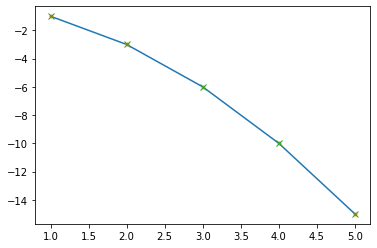

In [15]:
fig, ax = plt.subplots()
ax.plot(l, dtheta_Plm_scipy)
ax.plot(l, dtheta_Plm_tridiag, '.')
ax.plot(l, -l*(l+1)/2., 'x')